In [2]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Load file paths

In [6]:
RAV = "../data/archive/audio_speech_actors_01-24/"
dir_list = os.listdir(RAV)
dir_list.sort()
print(dir_list)

['.DS_Store', 'Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [7]:
dir_list = dir_list[1:] # get rid of '.DS_Store'
# look at the RAV dataset
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_disgust        96
female_angry        96
female_sad          96
female_surprise     96
female_happy        96
male_angry          96
male_happy          96
female_disgust      96
female_fear         96
male_sad            96
male_fear           96
male_surprise       96
Name: labels, dtype: int64

## Data Exploration

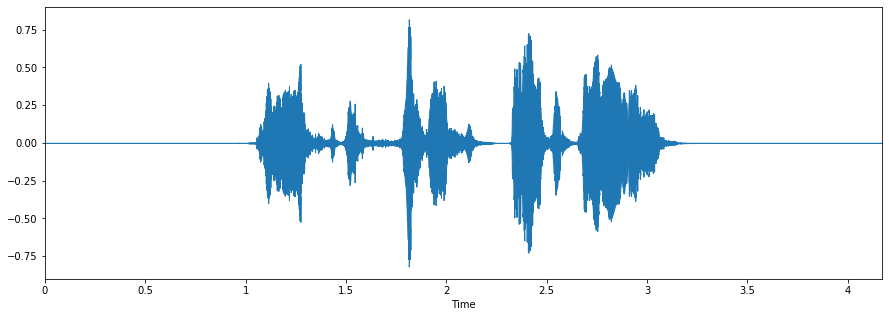

In [10]:
# Pick a track: female, intense angry, speaking "Dogs"
fname = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

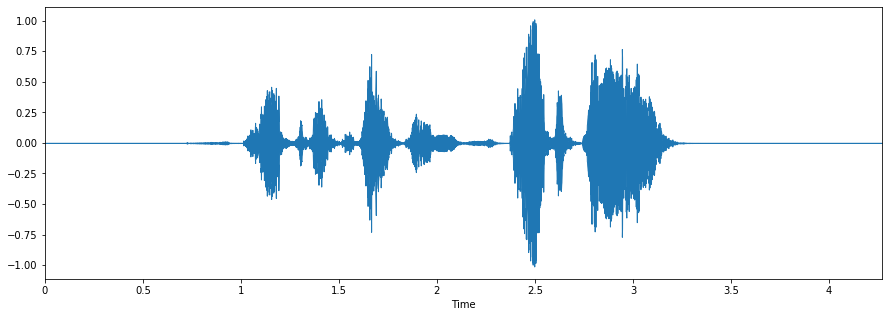

In [20]:
# Pick a track: female, intense angry, speaking "Kids"
fname = RAV + 'Actor_14/03-01-05-02-01-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

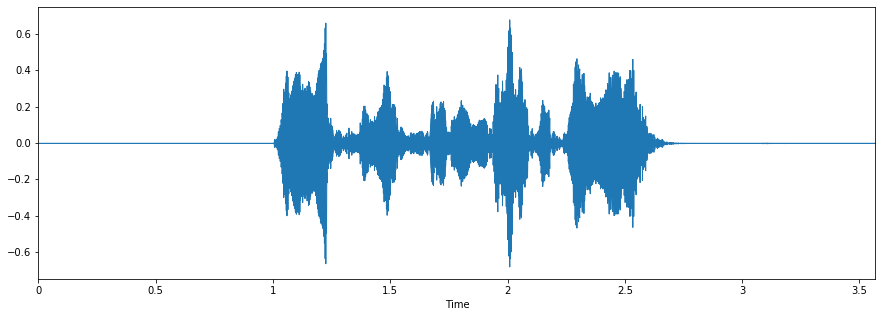

In [12]:
# Pick a track: male, intense angry, speaking "Dogs"
fname = RAV + 'Actor_13/03-01-05-02-02-01-13.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

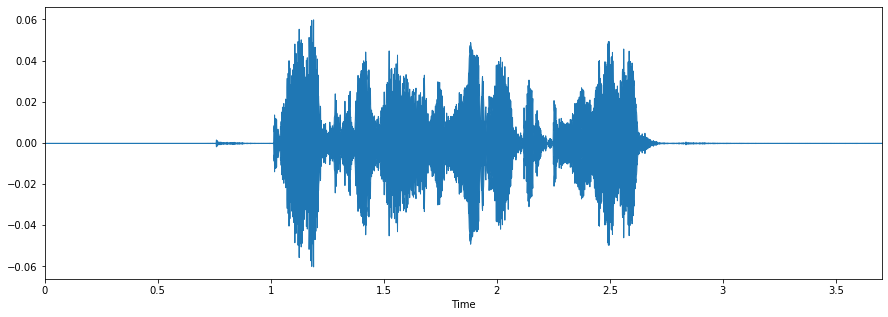

In [13]:
# Pick a track: female, surprised, speaking "Dogs"
fname = RAV + 'Actor_14/03-01-08-02-02-01-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

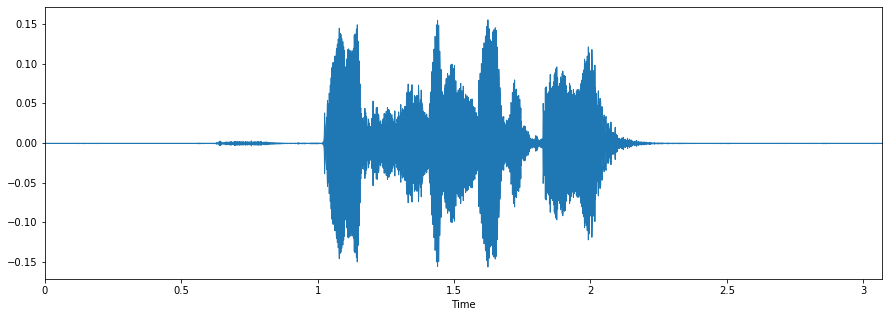

In [14]:
# Pick a track: male, surprised, speaking "Dogs"
fname = RAV + 'Actor_11/03-01-08-02-02-01-11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

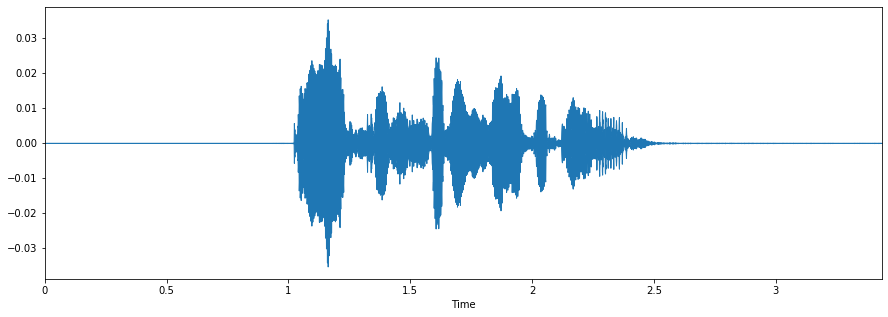

In [17]:
# Pick a track: female, neutral, speaking "Dogs"
fname = RAV + 'Actor_20/03-01-01-01-02-01-20.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

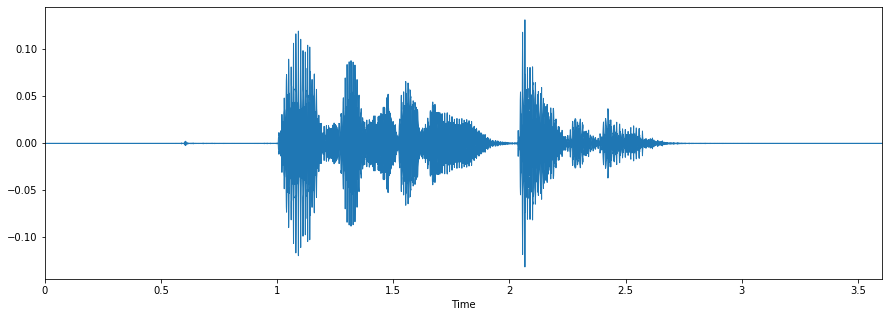

In [18]:
# Pick a track: male, neutral, speaking "Dogs"
fname = RAV + 'Actor_21/03-01-01-01-02-01-21.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

### Conclusion: 
Distinctive waveforms could be observed from the plot, even with diffirent sentences and different genders. This suggested the classification of emotions could possibly work.

## MFCC Transformation

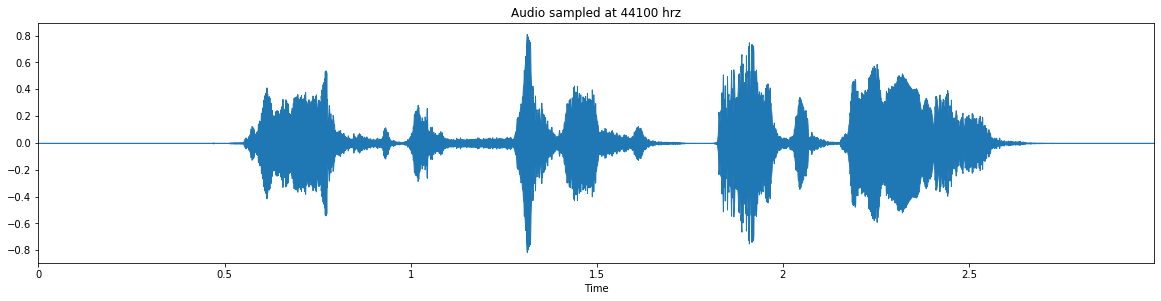

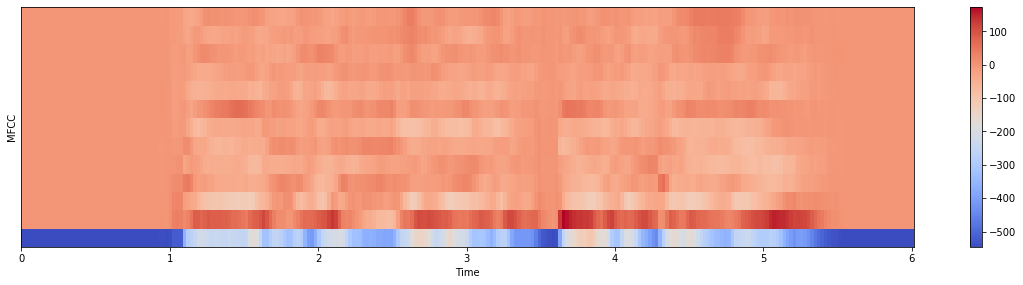

In [27]:
# Pick a track: female, intense angry, speaking "Dogs"
path = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()


259
259


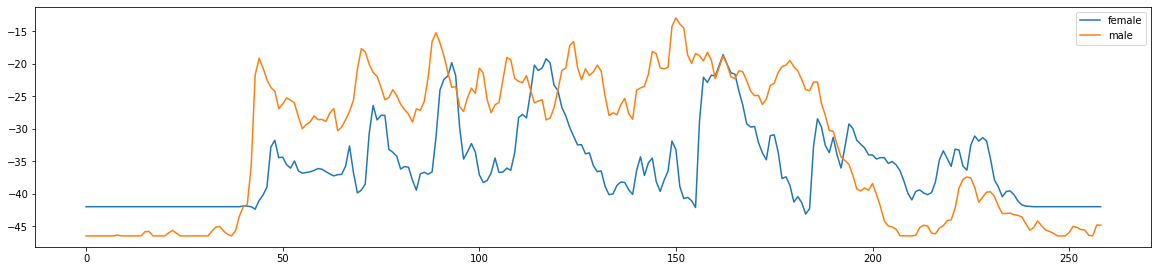

In [34]:
# MFCC audio waves

# Pick a track: female, intense angry, speaking "Dogs"
path = RAV + 'Actor_14/03-01-05-02-02-01-14.wav'  
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Pick a track: male, intense angry, speaking "Dogs"
path = RAV + 'Actor_13/03-01-05-02-02-01-13.wav' 
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()